# Continuous ensemble training
Now that the data, the network frameworks and the training loops are set up, we can investigate fruther.

In [16]:
# Reload module in case of changes
importlib.reload(utils)

<module 'lib.utils' from '/net/projects/scratch/winter/valid_until_31_July_2022/fheitzer/BAThesis-code/notebooks/../lib/utils.py'>

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd

import sys; sys.path.insert(0, '..')
import importlib

from lib import data, networks, training, utils

# Initialize the models

In [2]:
# load 10 class data
train_ds_pre, train_ds_post, test_ds, train_generator, test_generator = data.load_data(rotation=30)
dataset_shape = (tf.TensorSpec(shape=(28,28,1), dtype=tf.float64),
                tf.TensorSpec(shape=(10,), dtype=tf.float32),
                tf.TensorSpec(shape=(), dtype=tf.int32),
                tf.TensorSpec(shape=(10,), dtype=tf.float32))

num_classes = 10
# Small model
model1 = networks.NN([128, 128], num_classes)
# Broad Model
model2 = networks.NN([512], num_classes)
# Mixed Model
#model3a = networks.NN([256, 256], num_classes)

model3b = networks.CNN([(32, 3), (64, 5)])
# cnn
model4 = networks.CNN([(32, 3), (64, 5), (128, 7)], num_classes)
# cnn small
model5 = networks.CNN([(16, 3), (32, 3), (64, 5)], num_classes)
# ensemble
ensemble = networks.Ensemble([model1, model2, model3b, model4, model5])

model1.load_weights('../models/NN128128extra')
model2.load_weights('../models/NN512extra')
model3b.load_weights('../models/CNN3264extra')
model4.load_weights('../models/CNN3264128extra')
model5.load_weights('../models/CNN163264extra')

2022-04-27 21:36:05.495323: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-27 21:36:05.517800: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2496000000 Hz
2022-04-27 21:36:05.518771: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x561b7741daf0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-04-27 21:36:05.518790: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


# Plot Cycle Accuracies

In [3]:
files = ["bigup2_r180_e1_b1_c36_d15000",
         "bigup3_r180_e1_b1_c60_d15000", 
         "bigup_r180_e1_b1_c90_d15000", 
         "Longcovid_r90_e1_b1_c90_d15000", 
         "AYO_r180_e1_b1_c360_d15000",
         "Longcovid_r30_e1_b1_c90_d15000",
         "fivesteps_r180_e1_b1_c900_d15000"]

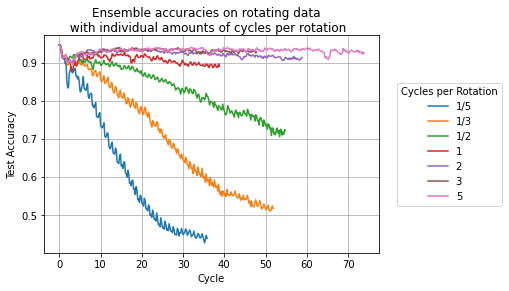

In [4]:
utils.plot_multiple_ensemble_accuracies(files)

In [5]:
jumpfiles = ["Jump_r5_e1_b1_c24_d15000",
             "Jump_r10_e1_b1_c24_d15000",
             "Jump_r20_e1_b1_c24_d15000",
             "Jump_r25_e1_b1_c24_d15000"]

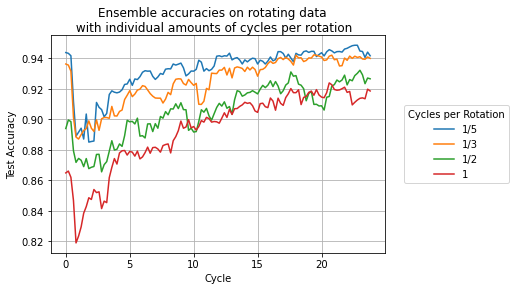

In [6]:
utils.plot_multiple_ensemble_accuracies(jumpfiles)

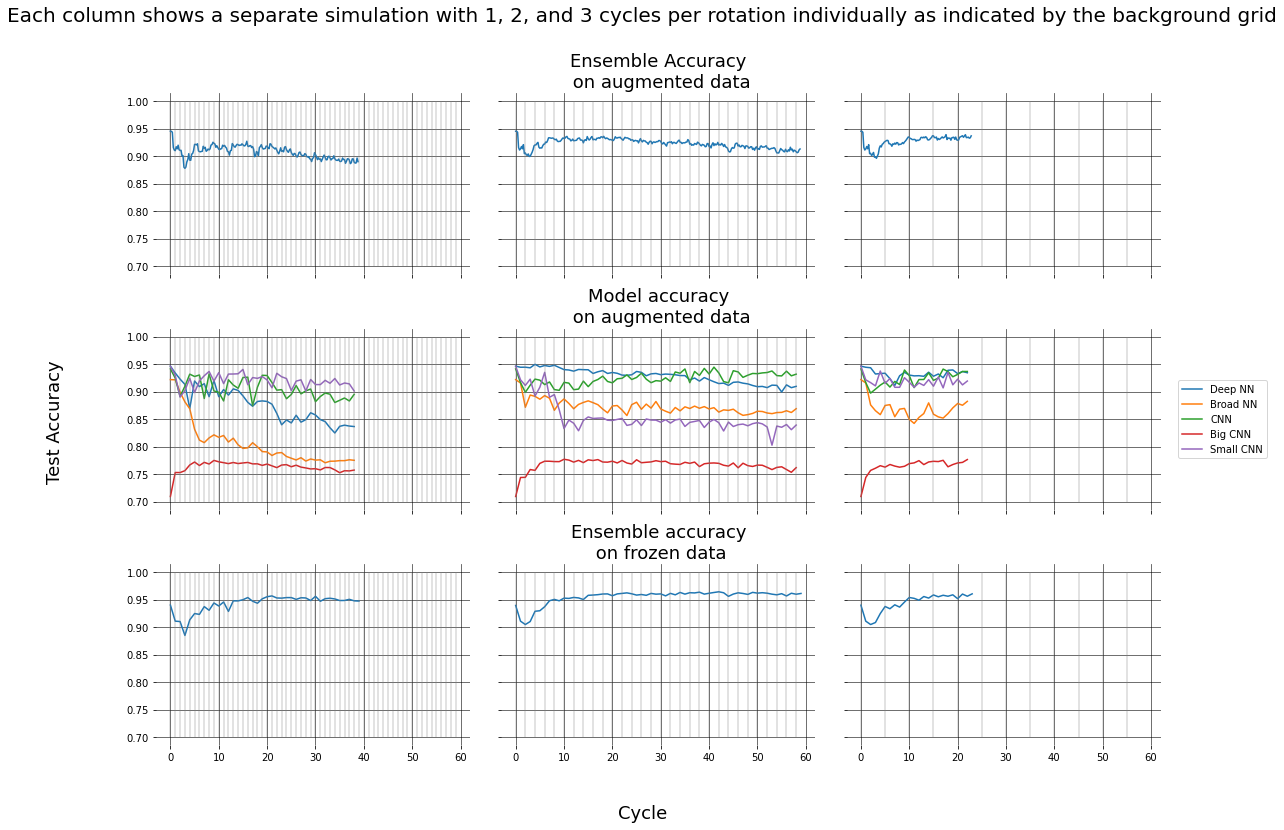

In [20]:
utils.plot_cycle_accuracies_grid(files[3:-2] + [files[-1]])

# Plot Cycle Data Collection

## 180 degrees in 59/360 cycles

6787.0 collected datapoints labeled correct
238.0 collected datapoints were labeled wrong
271 datapoints were not classified.


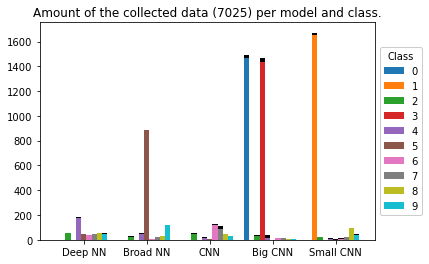

In [72]:
utils.plot_cycles_oneline(ensemble, "AYO_r180_e1_b1_c360_d15000", only_some=[-2,-1])

## 30 degrees in 48/90 cycles

5872.0 collected datapoints labeled correct
234.0 collected datapoints were labeled wrong
187 datapoints were not classified.


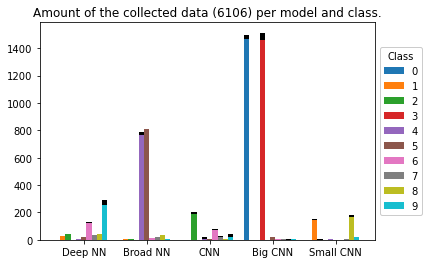

In [74]:
utils.plot_cycles_oneline(ensemble, "Longcovid_r30_e1_b1_c90_d15000", only_some=[-2,-1])

## 90 degrees in 39/90 cycles

Cycle:  0
7701.0 collected datapoints labeled correct
328.0 collected datapoints were labeled wrong
544 datapoints were not classified.


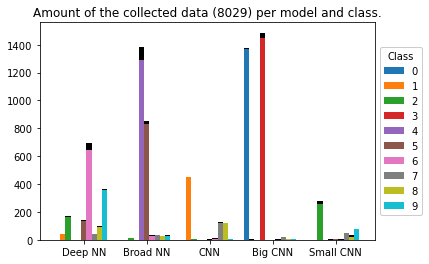

In [29]:
utils.plot_cycles_oneline(ensemble, "Longcovid_r90_e1_b1_c90_d15000", only_some=[-2,-1])

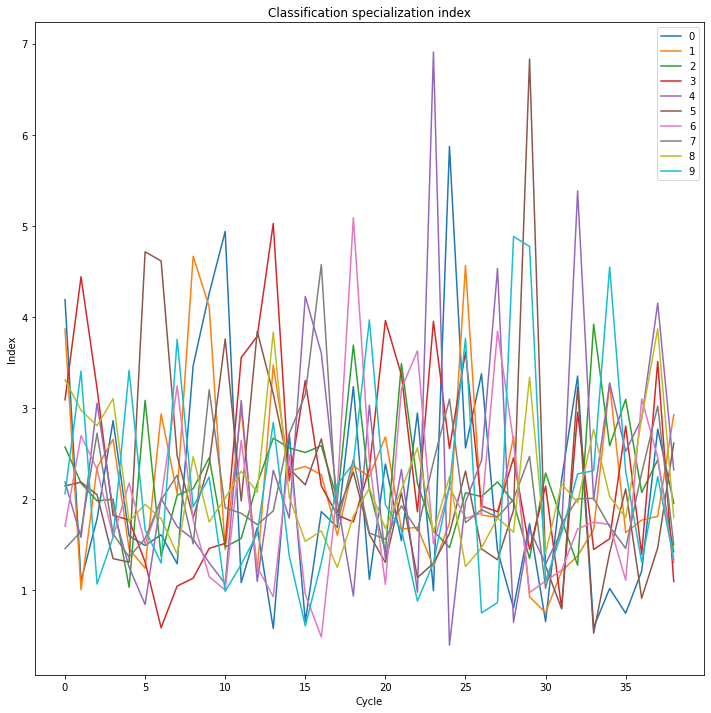

In [35]:
utils.classification_specialization(ensemble, "Longcovid_r90_e1_b1_c90_d15000")

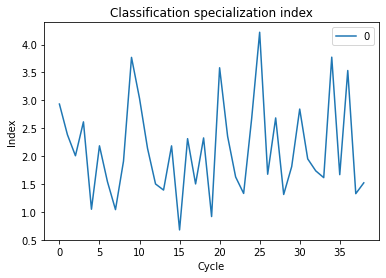

In [27]:
utils.classification_specialization_mean(ensemble, "Longcovid_r90_e1_b1_c90_d15000")

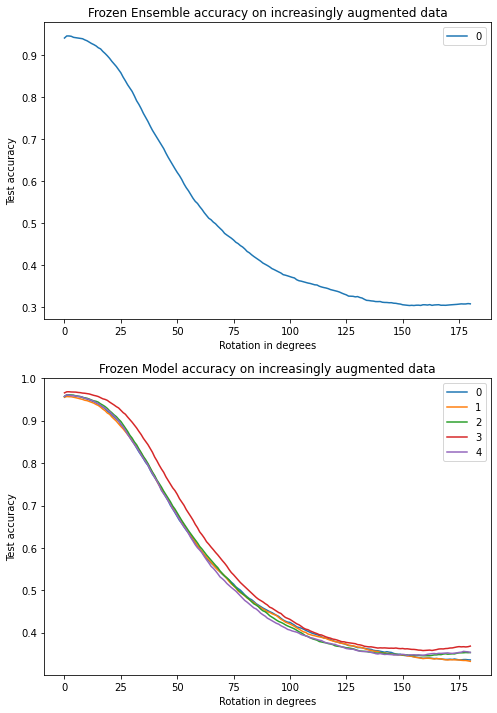

In [11]:
utils.plot_frozen_model('Frozenmodel_r180_c180')

Cycle:  0
334.0 collected datapoints labeled correct
99.0 collected datapoints were labeled wrong
512 datapoints were not classified.


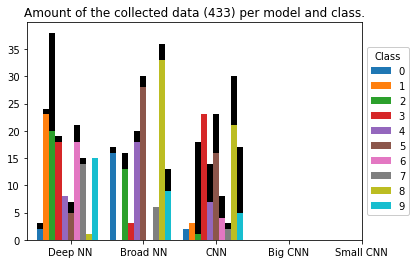

Cycle:  1
1512.0 collected datapoints labeled correct
174.0 collected datapoints were labeled wrong
993 datapoints were not classified.


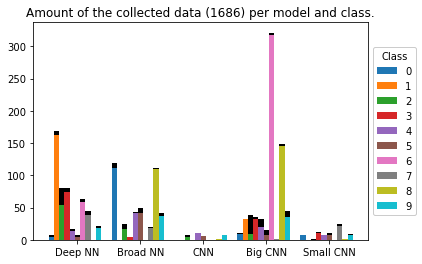

Cycle:  2
1817.0 collected datapoints labeled correct
212.0 collected datapoints were labeled wrong
859 datapoints were not classified.


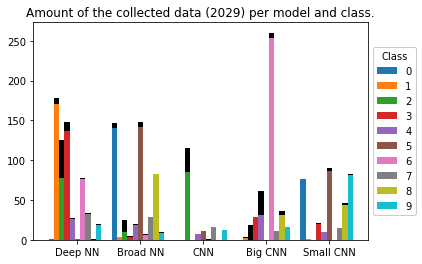

Cycle:  3
1488.0 collected datapoints labeled correct
256.0 collected datapoints were labeled wrong
665 datapoints were not classified.


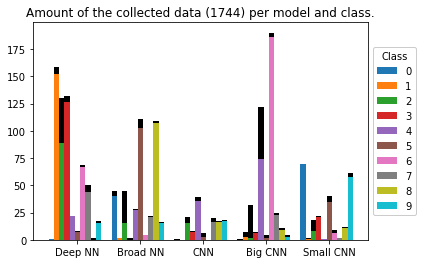

Cycle:  4
1822.0 collected datapoints labeled correct
250.0 collected datapoints were labeled wrong
559 datapoints were not classified.


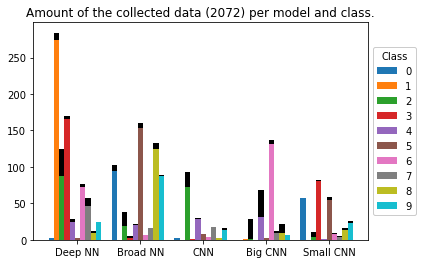

Cycle:  5
1915.0 collected datapoints labeled correct
274.0 collected datapoints were labeled wrong
528 datapoints were not classified.


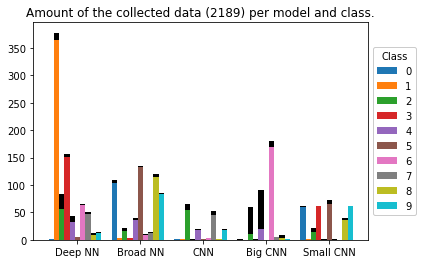

Cycle:  6
2025.0 collected datapoints labeled correct
245.0 collected datapoints were labeled wrong
521 datapoints were not classified.


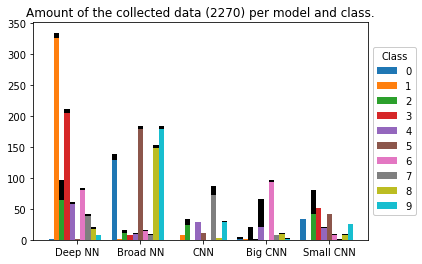

Cycle:  7
2311.0 collected datapoints labeled correct
229.0 collected datapoints were labeled wrong
439 datapoints were not classified.


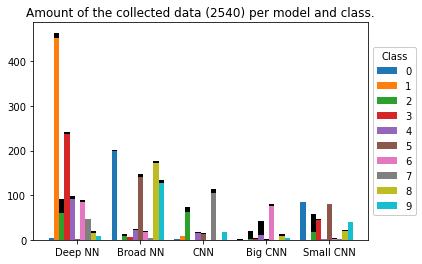

Cycle:  8


In [ ]:
utils.plot_cycles_oneline(ensemble, "Firstsshrun")